# Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
pip install "flaml[automl]"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.2/295.2 kB 4.5 MB/s eta 0:00:00


In [33]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, learning_curve,ShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error,get_scorer_names
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold,cross_validate
from flaml import AutoML
import matplotlib.pyplot as plt
from flaml.automl.ml import sklearn_metric_loss_score
from flaml.automl.data import get_output_from_log
import pickle
import seaborn as sns


In [5]:
rel_path = "/content/drive/MyDrive/clean_data_final.csv"
df = pd.read_csv(rel_path)


In [71]:
df=df[df["PFPI_MINUTES"]>0]

<ipython-input-72-b49f1490cfc7>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=df["PFPI_MINUTES"])


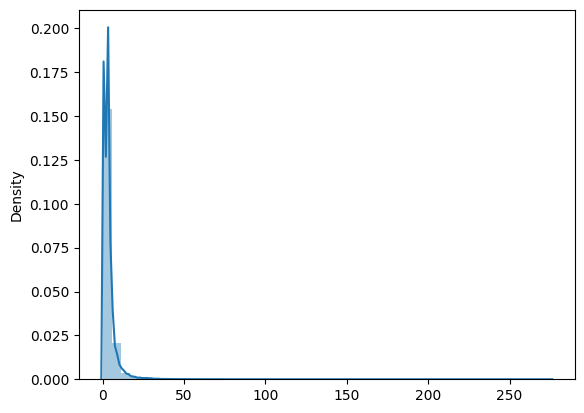

In [72]:
sns.distplot(x=df["PFPI_MINUTES"])
print()


# New section

In [6]:
# Explore the Data
print("Head of the dataset:")
print(df.head())


Head of the dataset:
   TRAIN_SERVICE_CODE_AFFECTED SERVICE_GROUP_CODE_AFFECTED ENGLISH_DAY_TYPE  \
0                     22215003                        EK03               BH   
1                     22215003                        EK03               BH   
2                     22218000                        EK99               BH   
3                     22218000                        EK99               BH   
4                     22218000                        EK99               BH   

  APP_TIMETABLE_FLAG_AFF  UNIT_CLASS_AFFECTED INCIDENT_REASON  \
0                      Y                375.0               M   
1                      Y                375.0               M   
2                      Y                375.0               M   
3                      Y                375.0               M   
4                      Y                375.0               M   

  PERFORMANCE_EVENT_CODE  PFPI_MINUTES    Lat_OR   Lon_OR  ...  \
0                      M           9.0  51.5465

In [7]:
print("NANs:")
df.isnull().mean()

NANs:


TRAIN_SERVICE_CODE_AFFECTED    0.0
SERVICE_GROUP_CODE_AFFECTED    0.0
ENGLISH_DAY_TYPE               0.0
APP_TIMETABLE_FLAG_AFF         0.0
UNIT_CLASS_AFFECTED            0.0
INCIDENT_REASON                0.0
PERFORMANCE_EVENT_CODE         0.0
PFPI_MINUTES                   0.0
Lat_OR                         0.0
Lon_OR                         0.0
Lat_DES                        0.0
Lon_DES                        0.0
ORIG_MONTH_SIN                 0.0
ORIG_MONTH_COS                 0.0
ORIG_DAY_SIN                   0.0
ORIG_DAY_COS                   0.0
ORIG_HOUR_SIN                  0.0
ORIG_HOUR_COS                  0.0
ORIG_MINUTE_SIN                0.0
ORIG_MINUTE_COS                0.0
DEST_MONTH_SIN                 0.0
DEST_MONTH_COS                 0.0
DEST_DAY_SIN                   0.0
DEST_DAY_COS                   0.0
DEST_HOUR_SIN                  0.0
DEST_HOUR_COS                  0.0
DEST_MINUTE_SIN                0.0
DEST_MINUTE_COS                0.0
dtype: float64

# Load Data and split train/test

In [73]:
# Split data into features and target
X = df.loc[:, df.columns != 'PFPI_MINUTES']
y = np.log(df['PFPI_MINUTES'])

# Split data into train, test and validation sets: 70% train, 15% validation, 15% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(313800, 27) (134486, 27) (313800,) (134486,)


# Preprocessing

In [74]:
print("Before preprocessing - NAs - Train, Test")
display(X_train.isnull().mean().sort_values(ascending=False)*100)
display(X_test.isnull().mean().sort_values(ascending=False)*100)

print("Before preprocessing - Summary Statistics - Train, Test")
display(X_train.describe())
display(X_test.describe())


Before preprocessing - NAs - Train, Test


TRAIN_SERVICE_CODE_AFFECTED    0.0
ORIG_DAY_COS                   0.0
DEST_MINUTE_SIN                0.0
DEST_HOUR_COS                  0.0
DEST_HOUR_SIN                  0.0
DEST_DAY_COS                   0.0
DEST_DAY_SIN                   0.0
DEST_MONTH_COS                 0.0
DEST_MONTH_SIN                 0.0
ORIG_MINUTE_COS                0.0
ORIG_MINUTE_SIN                0.0
ORIG_HOUR_COS                  0.0
ORIG_HOUR_SIN                  0.0
ORIG_DAY_SIN                   0.0
SERVICE_GROUP_CODE_AFFECTED    0.0
ORIG_MONTH_COS                 0.0
ORIG_MONTH_SIN                 0.0
Lon_DES                        0.0
Lat_DES                        0.0
Lon_OR                         0.0
Lat_OR                         0.0
PERFORMANCE_EVENT_CODE         0.0
INCIDENT_REASON                0.0
UNIT_CLASS_AFFECTED            0.0
APP_TIMETABLE_FLAG_AFF         0.0
ENGLISH_DAY_TYPE               0.0
DEST_MINUTE_COS                0.0
dtype: float64

TRAIN_SERVICE_CODE_AFFECTED    0.0
ORIG_DAY_COS                   0.0
DEST_MINUTE_SIN                0.0
DEST_HOUR_COS                  0.0
DEST_HOUR_SIN                  0.0
DEST_DAY_COS                   0.0
DEST_DAY_SIN                   0.0
DEST_MONTH_COS                 0.0
DEST_MONTH_SIN                 0.0
ORIG_MINUTE_COS                0.0
ORIG_MINUTE_SIN                0.0
ORIG_HOUR_COS                  0.0
ORIG_HOUR_SIN                  0.0
ORIG_DAY_SIN                   0.0
SERVICE_GROUP_CODE_AFFECTED    0.0
ORIG_MONTH_COS                 0.0
ORIG_MONTH_SIN                 0.0
Lon_DES                        0.0
Lat_DES                        0.0
Lon_OR                         0.0
Lat_OR                         0.0
PERFORMANCE_EVENT_CODE         0.0
INCIDENT_REASON                0.0
UNIT_CLASS_AFFECTED            0.0
APP_TIMETABLE_FLAG_AFF         0.0
ENGLISH_DAY_TYPE               0.0
DEST_MINUTE_COS                0.0
dtype: float64

Before preprocessing - Summary Statistics - Train, Test


,TRAIN_SERVICE_CODE_AFFECTED,UNIT_CLASS_AFFECTED,Lat_OR,Lon_OR,Lat_DES,Lon_DES,ORIG_MONTH_SIN,ORIG_MONTH_COS,ORIG_DAY_SIN,ORIG_DAY_COS,...,ORIG_MINUTE_SIN,ORIG_MINUTE_COS,DEST_MONTH_SIN,DEST_MONTH_COS,DEST_DAY_SIN,DEST_DAY_COS,DEST_HOUR_SIN,DEST_HOUR_COS,DEST_MINUTE_SIN,DEST_MINUTE_COS
count,3.138000e+05,313800.000000,313800.000000,313800.000000,313800.000000,313800.000000,313800.000000,313800.000000,313800.000000,3.138000e+05,...,3.138000e+05,3.138000e+05,313800.000000,313800.000000,313800.000000,3.138000e+05,313800.000000,3.138000e+05,3.138000e+05,3.138000e+05
mean,2.212801e+07,457.062349,51.524543,-0.108421,51.526427,-0.105994,0.591209,0.724276,0.639179,-4.891796e-02,...,1.273607e-02,-4.677335e-03,0.591228,0.724278,0.639221,-4.891511e-02,0.831603,2.705385e-02,7.389327e-03,-1.869860e-03
std,6.690419e+05,152.818982,0.059306,0.091458,0.054891,0.097782,0.273998,0.225435,0.320891,6.972000e-01,...,7.010580e-01,7.129774e-01,0.273976,0.225405,0.320880,6.971666e-01,0.194548,5.194768e-01,7.081542e-01,7.060189e-01
min,2.123400e+07,313.000000,51.378426,-0.396494,51.378426,-0.396494,0.104528,0.309017,-0.104528,-1.000000e+00,...,-1.000000e+00,-1.000000e+00,0.104528,0.309017,-0.104528,-1.000000e+00,0.000000,-7.431448e-01,-1.000000e+00,-1.000000e+00
25%,2.192100e+07,375.000000,51.491410,-0.151360,51.497990,-0.151360,0.406737,0.500000,0.406737,-7.431448e-01,...,-6.691306e-01,-7.431448e-01,0.406737,0.500000,0.406737,-7.431448e-01,0.743145,-4.067366e-01,-7.431448e-01,-6.691306e-01
50%,2.221400e+07,378.000000,51.534000,-0.075130,51.532500,-0.072584,0.669131,0.743145,0.743145,2.832769e-16,...,5.665539e-16,-1.836970e-16,0.669131,0.743145,0.743145,2.832769e-16,0.866025,2.832769e-16,5.665539e-16,-1.836970e-16
75%,2.221500e+07,710.000000,51.555480,-0.059820,51.548450,-0.049710,0.866025,0.913545,0.913545,5.877853e-01,...,7.431448e-01,7.431448e-01,0.866025,0.913545,0.913545,5.877853e-01,0.951057,5.000000e-01,7.431448e-01,6.691306e-01
max,2.523500e+07,710.000000,51.701930,0.329879,51.701930,0.329879,0.951057,0.994522,1.000000,9.945219e-01,...,1.000000e+00,1.000000e+00,0.951057,0.994522,1.000000,9.945219e-01,1.000000,1.000000e+00,1.000000e+00,1.000000e+00


,TRAIN_SERVICE_CODE_AFFECTED,UNIT_CLASS_AFFECTED,Lat_OR,Lon_OR,Lat_DES,Lon_DES,ORIG_MONTH_SIN,ORIG_MONTH_COS,ORIG_DAY_SIN,ORIG_DAY_COS,...,ORIG_MINUTE_SIN,ORIG_MINUTE_COS,DEST_MONTH_SIN,DEST_MONTH_COS,DEST_DAY_SIN,DEST_DAY_COS,DEST_HOUR_SIN,DEST_HOUR_COS,DEST_MINUTE_SIN,DEST_MINUTE_COS
count,1.344860e+05,134486.000000,134486.000000,134486.000000,134486.000000,134486.000000,134486.000000,134486.000000,134486.000000,1.344860e+05,...,1.344860e+05,1.344860e+05,134486.000000,134486.000000,134486.000000,1.344860e+05,134486.000000,1.344860e+05,1.344860e+05,1.344860e+05
mean,2.213158e+07,456.503614,51.524595,-0.108758,51.526487,-0.106143,0.592342,0.722930,0.639117,-4.778034e-02,...,1.298364e-02,-5.967538e-03,0.592363,0.722926,0.639122,-4.795349e-02,0.831458,3.074469e-02,8.984546e-03,-4.454650e-03
std,6.738972e+05,152.516995,0.059295,0.091423,0.054912,0.097659,0.274660,0.225977,0.321234,6.971794e-01,...,7.008778e-01,7.131434e-01,0.274643,0.225957,0.321341,6.971141e-01,0.194969,5.193468e-01,7.093215e-01,7.048190e-01
min,2.123400e+07,313.000000,51.378426,-0.396494,51.378426,-0.396494,0.104528,0.309017,-0.104528,-1.000000e+00,...,-1.000000e+00,-1.000000e+00,0.104528,0.309017,-0.104528,-1.000000e+00,0.000000,-7.431448e-01,-1.000000e+00,-1.000000e+00
25%,2.192100e+07,375.000000,51.491410,-0.151360,51.497990,-0.151360,0.406737,0.500000,0.406737,-7.431448e-01,...,-6.691306e-01,-7.431448e-01,0.406737,0.500000,0.406737,-7.431448e-01,0.743145,-4.067366e-01,-7.431448e-01,-6.691306e-01
50%,2.221400e+07,378.000000,51.534000,-0.075130,51.532500,-0.075070,0.669131,0.743145,0.743145,2.832769e-16,...,5.665539e-16,-1.836970e-16,0.669131,0.743145,0.743145,2.832769e-16,0.866025,2.832769e-16,5.665539e-16,-1.836970e-16
75%,2.221500e+07,710.000000,51.555480,-0.059820,51.548450,-0.049710,0.866025,0.913545,0.913545,5.877853e-01,...,7.431448e-01,7.431448e-01,0.866025,0.913545,0.913545,5.877853e-01,0.951057,5.000000e-01,7.431448e-01,6.691306e-01
max,2.523500e+07,710.000000,51.701930,0.250912,51.701930,0.329879,0.951057,0.994522,1.000000,9.945219e-01,...,1.000000e+00,1.000000e+00,0.951057,0.994522,1.000000,9.945219e-01,1.000000,1.000000e+00,1.000000e+00,1.000000e+00


In [75]:

# Build Pipeline
num_transformer = MinMaxScaler()
cat_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output = False)
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

transformer = make_column_transformer((num_transformer, ['Lat_OR','Lon_OR', 'Lat_DES','Lon_DES']),
                                  (cat_transformer, ['ENGLISH_DAY_TYPE', 'SERVICE_GROUP_CODE_AFFECTED', 'INCIDENT_REASON',
                                                        'UNIT_CLASS_AFFECTED', 'TRAIN_SERVICE_CODE_AFFECTED',
                                                     'PERFORMANCE_EVENT_CODE',
                                                     'APP_TIMETABLE_FLAG_AFF']),
                                remainder = 'passthrough')
pipe = Pipeline([('transformer', transformer)])


In [76]:
pipe.fit(X_train)
X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)


X_train = pd.DataFrame(X_train, columns=pipe.get_feature_names_out())
X_test = pd.DataFrame(X_test, columns=pipe.get_feature_names_out())


In [77]:
print("After preprocessing - NAs - Train, Test")
display(X_train.isnull().mean().sort_values(ascending=False)*100)
display(X_test.isnull().mean().sort_values(ascending=False)*100)


print("After preprocessing - Summary Statistics - Train, Test")
display(X_train.describe())
display(X_test.describe())


After preprocessing - NAs - Train, Test


minmaxscaler__Lat_OR                                   0.0
onehotencoder__TRAIN_SERVICE_CODE_AFFECTED_22215003    0.0
onehotencoder__PERFORMANCE_EVENT_CODE_M                0.0
onehotencoder__PERFORMANCE_EVENT_CODE_A                0.0
onehotencoder__TRAIN_SERVICE_CODE_AFFECTED_25235001    0.0
                                                      ... 
onehotencoder__UNIT_CLASS_AFFECTED_315.0               0.0
onehotencoder__UNIT_CLASS_AFFECTED_317.0               0.0
onehotencoder__UNIT_CLASS_AFFECTED_321.0               0.0
onehotencoder__UNIT_CLASS_AFFECTED_375.0               0.0
remainder__DEST_MINUTE_COS                             0.0
Length: 69, dtype: float64

minmaxscaler__Lat_OR                                   0.0
onehotencoder__TRAIN_SERVICE_CODE_AFFECTED_22215003    0.0
onehotencoder__PERFORMANCE_EVENT_CODE_M                0.0
onehotencoder__PERFORMANCE_EVENT_CODE_A                0.0
onehotencoder__TRAIN_SERVICE_CODE_AFFECTED_25235001    0.0
                                                      ... 
onehotencoder__UNIT_CLASS_AFFECTED_315.0               0.0
onehotencoder__UNIT_CLASS_AFFECTED_317.0               0.0
onehotencoder__UNIT_CLASS_AFFECTED_321.0               0.0
onehotencoder__UNIT_CLASS_AFFECTED_375.0               0.0
remainder__DEST_MINUTE_COS                             0.0
Length: 69, dtype: float64

After preprocessing - Summary Statistics - Train, Test


,minmaxscaler__Lat_OR,minmaxscaler__Lon_OR,minmaxscaler__Lat_DES,minmaxscaler__Lon_DES,onehotencoder__ENGLISH_DAY_TYPE_BD,onehotencoder__ENGLISH_DAY_TYPE_BH,onehotencoder__ENGLISH_DAY_TYPE_SA,onehotencoder__ENGLISH_DAY_TYPE_SU,onehotencoder__ENGLISH_DAY_TYPE_WD,onehotencoder__SERVICE_GROUP_CODE_AFFECTED_EK01,...,remainder__ORIG_MINUTE_SIN,remainder__ORIG_MINUTE_COS,remainder__DEST_MONTH_SIN,remainder__DEST_MONTH_COS,remainder__DEST_DAY_SIN,remainder__DEST_DAY_COS,remainder__DEST_HOUR_SIN,remainder__DEST_HOUR_COS,remainder__DEST_MINUTE_SIN,remainder__DEST_MINUTE_COS
count,313800.000000,313800.000000,313800.000000,313800.000000,313800.000000,313800.000000,313800.000000,313800.000000,313800.000000,313800.000000,...,3.138000e+05,3.138000e+05,313800.000000,313800.000000,313800.000000,3.138000e+05,313800.000000,3.138000e+05,3.138000e+05,3.138000e+05
mean,0.451670,0.396591,0.457493,0.399933,0.000051,0.011259,0.089841,0.071246,0.827604,0.428505,...,1.273607e-02,-4.677335e-03,0.591228,0.724278,0.639221,-4.891511e-02,0.831603,2.705385e-02,7.389327e-03,-1.869860e-03
std,0.183323,0.125911,0.169675,0.134617,0.007140,0.105508,0.285954,0.257236,0.377725,0.494863,...,7.010580e-01,7.129774e-01,0.273976,0.225405,0.320880,6.971666e-01,0.194548,5.194768e-01,7.081542e-01,7.060189e-01
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000e+00,-1.000000e+00,0.104528,0.309017,-0.104528,-1.000000e+00,0.000000,-7.431448e-01,-1.000000e+00,-1.000000e+00
25%,0.349251,0.337477,0.369591,0.337477,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,-6.691306e-01,-7.431448e-01,0.406737,0.500000,0.406737,-7.431448e-01,0.743145,-4.067366e-01,-7.431448e-01,-6.691306e-01
50%,0.480903,0.442423,0.476266,0.445928,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,5.665539e-16,-1.836970e-16,0.669131,0.743145,0.743145,2.832769e-16,0.866025,2.832769e-16,5.665539e-16,-1.836970e-16
75%,0.547301,0.463500,0.525570,0.477419,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,7.431448e-01,7.431448e-01,0.866025,0.913545,0.913545,5.877853e-01,0.951057,5.000000e-01,7.431448e-01,6.691306e-01
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000e+00,1.000000e+00,0.951057,0.994522,1.000000,9.945219e-01,1.000000,1.000000e+00,1.000000e+00,1.000000e+00


,minmaxscaler__Lat_OR,minmaxscaler__Lon_OR,minmaxscaler__Lat_DES,minmaxscaler__Lon_DES,onehotencoder__ENGLISH_DAY_TYPE_BD,onehotencoder__ENGLISH_DAY_TYPE_BH,onehotencoder__ENGLISH_DAY_TYPE_SA,onehotencoder__ENGLISH_DAY_TYPE_SU,onehotencoder__ENGLISH_DAY_TYPE_WD,onehotencoder__SERVICE_GROUP_CODE_AFFECTED_EK01,...,remainder__ORIG_MINUTE_SIN,remainder__ORIG_MINUTE_COS,remainder__DEST_MONTH_SIN,remainder__DEST_MONTH_COS,remainder__DEST_DAY_SIN,remainder__DEST_DAY_COS,remainder__DEST_HOUR_SIN,remainder__DEST_HOUR_COS,remainder__DEST_MINUTE_SIN,remainder__DEST_MINUTE_COS
count,134486.000000,134486.000000,134486.000000,134486.000000,134486.000000,134486.000000,134486.000000,134486.000000,134486.000000,134486.000000,...,1.344860e+05,1.344860e+05,134486.000000,134486.000000,134486.000000,1.344860e+05,134486.000000,1.344860e+05,1.344860e+05,1.344860e+05
mean,0.451830,0.396127,0.457681,0.399727,0.000022,0.010856,0.088760,0.071294,0.829068,0.429584,...,1.298364e-02,-5.967538e-03,0.592363,0.722926,0.639122,-4.795349e-02,0.831458,3.074469e-02,8.984546e-03,-4.454650e-03
std,0.183289,0.125863,0.169743,0.134447,0.004723,0.103626,0.284398,0.257316,0.376451,0.495019,...,7.008778e-01,7.131434e-01,0.274643,0.225957,0.321341,6.971141e-01,0.194969,5.193468e-01,7.093215e-01,7.048190e-01
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000e+00,-1.000000e+00,0.104528,0.309017,-0.104528,-1.000000e+00,0.000000,-7.431448e-01,-1.000000e+00,-1.000000e+00
25%,0.349251,0.337477,0.369591,0.337477,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,-6.691306e-01,-7.431448e-01,0.406737,0.500000,0.406737,-7.431448e-01,0.743145,-4.067366e-01,-7.431448e-01,-6.691306e-01
50%,0.480903,0.442423,0.476266,0.442505,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,5.665539e-16,-1.836970e-16,0.669131,0.743145,0.743145,2.832769e-16,0.866025,2.832769e-16,5.665539e-16,-1.836970e-16
75%,0.547301,0.463500,0.525570,0.477419,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,7.431448e-01,7.431448e-01,0.866025,0.913545,0.913545,5.877853e-01,0.951057,5.000000e-01,7.431448e-01,6.691306e-01
max,1.000000,0.891286,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000e+00,1.000000e+00,0.951057,0.994522,1.000000,9.945219e-01,1.000000,1.000000e+00,1.000000e+00,1.000000e+00


# Baseline Model

In [78]:
import numpy as np
# "Learn" the mean from the training data
mean_train = np.mean(y_train)
# Get predictions on the test set
baseline_predictions = np.ones(y_test.shape) * mean_train
# Compute MSE
mse_baseline = mean_squared_error(y_test, baseline_predictions)
print("Baseline MSE is {:.2f}".format(mse_baseline))


Baseline MSE is 0.59


# Basic Model

In [79]:
# define basic model
basic_XGB = XGBRegressor(max_depth=10, n_estimators=100, learning_rate=0.1)
cv_results_basic_XGB = cross_validate(basic_XGB, X_train, y_train, cv=5, scoring='neg_mean_squared_error')


In [80]:
cv_results_basic_XGB['test_score']


array([-0.2538766 , -0.2544671 , -0.25397553, -0.25351686, -0.24984686])

In [81]:
print("Basic Model MSE is {:.2f}".format(abs(cv_results_basic_XGB['test_score'].mean())))


Basic Model MSE is 0.25


# Model with Randomized Search

In [82]:
XGB_hyper_params = XGBRegressor()


In [83]:
# Parameters
parameters = {'booster':['gbtree'], # which booster to use: gbtree and dart use tree based models while gblinear uses linear functions.
             'nthread': [4], # number of parallel threads to use during training -> set equal to n° of CPU cores
              'learning_rate': [0.03, 0.05, 0.07], #hyperparameter that scales the contribution of each tree in the ensemble
              'max_depth': [3, 5, 7], # Maximum depth of a tree
              'min_child_weight': [1,2,4], #  controls the minimum sum of instance weight (hessian) needed in a child. It is used to control overfitting.
              }


Best parameters:  {'nthread': 4, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.07, 'booster': 'gbtree'}


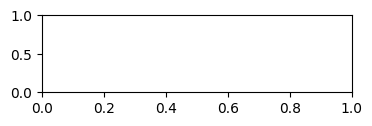

In [85]:
# Set random search
random_search = RandomizedSearchCV(XGB_hyper_params, parameters, random_state=42, n_jobs=-1,cv=5, scoring='neg_mean_squared_error')
# Fit the model
random_search.fit(X_train, y_train)
# Print the best parameters
print("Best parameters: ", random_search.best_params_)


In [86]:
print("Model with Randomized Search MSE is {:.2f}".format(abs(random_search.best_score_)))


Model with Randomized Search MSE is 0.27


# Model with parameters optimized with AutoML

In [87]:
automl = AutoML()
settings = {
    "time_budget": 600,  # total running time in seconds
    "metric": 'mse',  # primary metrics for regression can be chosen from: ['mae','mse','r2']
    "estimator_list": ['xgboost'],  # list of ML learners; we tune XGBoost in this example
    "task": 'regression',  # task type
    "log_file_name": 'train_delays_experiment_log_transf.log',  # flaml log file
    "seed": 7654321,  # random seed
}
automl.fit(X_train=X_train, y_train=y_train, **settings)

[flaml.automl.logger: 12-05 17:21:10] {1679} INFO - task = regression
[flaml.automl.logger: 12-05 17:21:10] {1690} INFO - Evaluation method: holdout
[flaml.automl.logger: 12-05 17:21:11] {1788} INFO - Minimizing error metric: mse
[flaml.automl.logger: 12-05 17:21:11] {1900} INFO - List of ML learners in AutoML Run: ['xgboost']
[flaml.automl.logger: 12-05 17:21:11] {2218} INFO - iteration 0, current learner xgboost
[flaml.automl.logger: 12-05 17:21:11] {2344} INFO - Estimated sufficient time budget=137724s. Estimated necessary time budget=138s.
[flaml.automl.logger: 12-05 17:21:11] {2391} INFO -  at 8.6s,	estimator xgboost's best error=0.4547,	best estimator xgboost's best error=0.4547
[flaml.automl.logger: 12-05 17:21:11] {2218} INFO - iteration 1, current learner xgboost
[flaml.automl.logger: 12-05 17:21:12] {2391} INFO -  at 9.1s,	estimator xgboost's best error=0.4547,	best estimator xgboost's best error=0.4547
[flaml.automl.logger: 12-05 17:21:12] {2218} INFO - iteration 2, current 

In [88]:
print('Best hyperparmeter config:', automl.best_config)
print('Best MSE on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))
print(automl.model.estimator)

Best hyperparmeter config: {'n_estimators': 887, 'max_leaves': 137, 'min_child_weight': 0.02936059342328297, 'learning_rate': 0.12579295781402905, 'subsample': 0.5142016001315275, 'colsample_bylevel': 0.8735639141913261, 'colsample_bytree': 1.0, 'reg_alpha': 0.2946397610169743, 'reg_lambda': 66.91492607248362}
Best MSE on validation data: 0.7581
Training duration of best run: 65.99 s
XGBRegressor(base_score=None, booster=None, callbacks=[],
             colsample_bylevel=0.8735639141913261, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy='lossguide', importance_type=None,
             interaction_constraints=None, learning_rate=0.12579295781402905,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=0, max_leaves=137,
             min_child_weight=0.02936059

In [89]:
y_pred = automl.predict(X_test)
print('mse', '=', sklearn_metric_loss_score('mse', y_pred, y_test))


mse = 0.2413210785117735


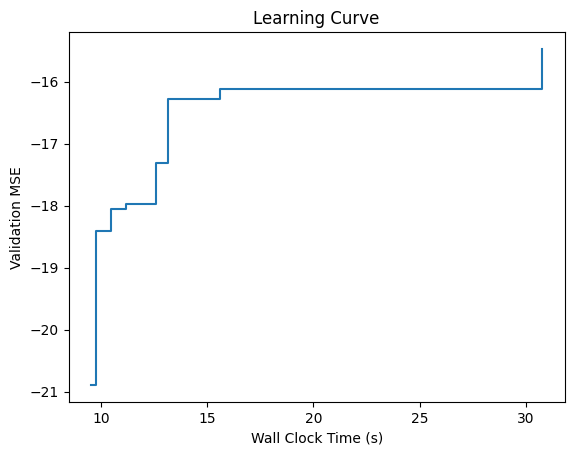

In [ ]:
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history =get_output_from_log(filename='train_delays_experiment.log', time_budget=60)
plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation MSE')
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()

# Saving the model

In [90]:
# Fit the model on training set
automl.model.estimator.fit(X_train, y_train)
# save the model to disk
filename = 'XGBoost_MSE_on_test_with_log_transf_0_24.sav'
pickle.dump(automl.model.estimator, open(filename, 'wb'))

In [91]:
automl.model.estimator

XGBRegressor(base_score=None, booster=None, callbacks=[],
             colsample_bylevel=0.8735639141913261, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy='lossguide', importance_type=None,
             interaction_constraints=None, learning_rate=0.12579295781402905,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=0, max_leaves=137,
             min_child_weight=0.02936059342328297, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=887,
             n_jobs=-1, num_parallel_tree=None, random_state=None, ...)

In [92]:
mse = 0.2413210785117735
rmse_original = np.exp(mse)

In [93]:
rmse_original

1.2729296800684615